# 앱 신규 사용자 쿠폰 발행 AB 테스트 결과 분석

## 📋 실험 개요
- **가설**: 앱 신규 쿠폰을 제공하면 앱 신규 사용자의 구매 전환율이 높아질 것이다. (쿠폰의 조건을 잘 설정하면 매출 감소를 최소화하여 총 매출액도 증가할 것이다)
- **실험군**: 쿠폰을 제공한 그룹 (Odd 그룹)
- **대조군**: 쿠폰을 제공하지 않은 그룹 (Even 그룹)
- **주요 지표**: 구매 전환율(Paid Ratio), ARPPU (Average Revenue Per Paying User)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 8)

print("필요한 라이브러리가 성공적으로 로드되었습니다.")

필요한 라이브러리가 성공적으로 로드되었습니다.


## 🔧 데이터 로드 및 전처리

In [19]:
def load_and_preprocess_data(file_path):
    """AB 테스트 데이터 로드 및 전처리"""
    # CSV 파일 로드
    df = pd.read_csv(file_path)
    
    # 컬럼명 확인
    print("원본 컬럼명:", df.columns.tolist())
    
    # Paid Ratio에서 % 제거하고 숫자로 변환
    df['Paid Ratio'] = df['Paid Ratio'].str.rstrip('%').astype(float) / 100
    
    # 천단위 콤마가 있는 컬럼들을 숫자로 변환
    numeric_columns = ['Total Users', 'Users Coupon Issued', 'Users Coupon Used', 
                      'Paid Users', 'Total Revenue', 'ARPU', 'ARPPU']
    
    for col in numeric_columns:
        if col in df.columns:
            df[col] = df[col].astype(str).str.replace(',', '').str.replace('"', '').astype(float)
    
    # 날짜 컬럼 변환
    df['Date'] = pd.to_datetime(df['Date'])
    
    return df

# 데이터 로드
df = load_and_preprocess_data('abtest_results_daily.csv')

print("\n=== 데이터 기본 정보 ===")
print(f"데이터 기간: {df['Date'].min()} ~ {df['Date'].max()}")
print(f"총 데이터 포인트: {len(df)}")
print("\n그룹별 데이터 포인트:")
print(df['User Group'].value_counts())

print("\n=== 데이터 샘플 ===")
df.head()

원본 컬럼명: ['Date', 'User Group', 'Total Users', 'Users Coupon Issued', 'Users Coupon Used', 'Paid Users', 'Paid Ratio', 'Total Revenue', 'ARPU', 'ARPPU']

=== 데이터 기본 정보 ===
데이터 기간: 2025-06-11 00:00:00 ~ 2025-07-13 00:00:00
총 데이터 포인트: 66

그룹별 데이터 포인트:
User Group
대조군(Even)    33
실험군(Odd)     33
Name: count, dtype: int64

=== 데이터 샘플 ===


,Date,User Group,Total Users,Users Coupon Issued,Users Coupon Used,Paid Users,Paid Ratio,Total Revenue,ARPU,ARPPU
0,2025-06-11,대조군(Even),898.0,0.0,0.0,43.0,0.048,828600.0,923.0,19270.0
1,2025-06-11,실험군(Odd),934.0,912.0,32.0,46.0,0.049,1107450.0,1186.0,24075.0
2,2025-06-12,대조군(Even),867.0,0.0,0.0,37.0,0.043,596700.0,688.0,16127.0
3,2025-06-12,실험군(Odd),889.0,862.0,39.0,50.0,0.056,795150.0,894.0,15903.0
4,2025-06-13,대조군(Even),1015.0,0.0,0.0,37.0,0.036,586950.0,578.0,15864.0


## 📊 탐색적 데이터 분석

In [20]:
# 기본 통계량
print("=== 그룹별 주요 지표 기본 통계량 ===")
key_metrics = ['Total Users', 'Paid Users', 'Paid Ratio', 'ARPPU']
summary_stats = df.groupby('User Group')[key_metrics].describe()
summary_stats

=== 그룹별 주요 지표 기본 통계량 ===


Total Users                                                  \
                 count         mean         std    min     25%     50%   
User Group                                                               
대조군(Even)         33.0  1275.242424  151.603106  867.0  1216.0  1285.0   
실험군(Odd)          33.0  1285.090909  143.032637  889.0  1217.0  1300.0   

                           Paid Users             ... Paid Ratio        ARPPU  \
               75%     max      count       mean  ...        75%    max count   
User Group                                        ...                           
대조군(Even)   1350.0  1566.0       33.0  65.060606  ...      0.055  0.064  33.0   
실험군(Odd)    1358.0  1587.0       33.0  75.000000  ...      0.064  0.072  33.0   

                                                                           \
                    mean          std      min      25%      50%      75%   
User Group                                                                  
대조군(Even)   16938.333333  2493.121383  11796.0  15647.0  16188.0  19270.0   
실험군(Odd)    16588.272727  2382.484080  12421.0  15305.0  16011.0  17677.0   

                     
                max  
User Group           
대조군(Even)   21029.0  
실험군(Odd)    24075.0  

[2 rows x 32 columns]

In [21]:
# 전체 기간 동안의 누적 지표
print("=== 전체 기간 누적 지표 ===")
total_summary = df.groupby('User Group').agg({
    'Total Users': 'sum',
    'Paid Users': 'sum', 
    'Total Revenue': 'sum',
    'Users Coupon Issued': 'sum',
    'Users Coupon Used': 'sum'
})

# 실제 전환율 계산
total_summary['Actual Conversion Rate'] = total_summary['Paid Users'] / total_summary['Total Users']
total_summary['Average ARPPU'] = total_summary['Total Revenue'] / total_summary['Paid Users']

# 쿠폰 사용률 계산 (실험군만)
coupon_usage_rate = total_summary.loc['실험군(Odd)', 'Users Coupon Used'] / total_summary.loc['실험군(Odd)', 'Users Coupon Issued']

print(total_summary.round(2))
print(f"\n실험군 쿠폰 사용률: {coupon_usage_rate:.2%}")

=== 전체 기간 누적 지표 ===
            Total Users  Paid Users  Total Revenue  Users Coupon Issued  \
User Group                                                                
대조군(Even)       42083.0      2147.0     36134850.0                  0.0   
실험군(Odd)        42408.0      2475.0     40921050.0              40816.0   

            Users Coupon Used  Actual Conversion Rate  Average ARPPU  
User Group                                                            
대조군(Even)                 0.0                    0.05       16830.39  
실험군(Odd)               3011.0                    0.06       16533.76  

실험군 쿠폰 사용률: 7.38%


## 🎯 구매 전환율 분석

In [22]:
print("=== 구매 전환율 분석 ===")

# 그룹별 전환율 통계
conversion_stats = df.groupby('User Group')['Paid Ratio'].agg(['mean', 'std', 'min', 'max', 'count']).round(4)
print("\n일별 전환율 통계:")
print(conversion_stats)

# 실제 누적 전환율
control_total_conversion = total_summary.loc['대조군(Even)', 'Actual Conversion Rate']
treatment_total_conversion = total_summary.loc['실험군(Odd)', 'Actual Conversion Rate']

print(f"\n=== 누적 전환율 (실제 계산) ===")
print(f"대조군: {control_total_conversion:.4f} ({control_total_conversion*100:.2f}%)")
print(f"실험군: {treatment_total_conversion:.4f} ({treatment_total_conversion*100:.2f}%)")

# 개선율 계산
conversion_lift = (treatment_total_conversion - control_total_conversion) / control_total_conversion * 100
print(f"전환율 개선: {conversion_lift:+.2f}%")

=== 구매 전환율 분석 ===

일별 전환율 통계:
              mean     std    min    max  count
User Group                                     
대조군(Even)   0.0507  0.0065  0.036  0.064     33
실험군(Odd)    0.0581  0.0076  0.041  0.072     33

=== 누적 전환율 (실제 계산) ===
대조군: 0.0510 (5.10%)
실험군: 0.0584 (5.84%)
전환율 개선: +14.39%


In [23]:
# 일별 전환율 차이 분석
daily_comparison = df.pivot(index='Date', columns='User Group', values='Paid Ratio')
daily_comparison['차이(실험군-대조군)'] = daily_comparison['실험군(Odd)'] - daily_comparison['대조군(Even)']

print("=== 일별 전환율 차이 (첫 10일) ===")
print(daily_comparison.head(10).round(4))

print(f"\n평균 일별 전환율 차이: {daily_comparison['차이(실험군-대조군)'].mean():+.4f}")
print(f"실험군이 더 좋았던 날: {(daily_comparison['차이(실험군-대조군)'] > 0).sum()}일 / {len(daily_comparison)}일")

=== 일별 전환율 차이 (첫 10일) ===
User Group  대조군(Even)  실험군(Odd)  차이(실험군-대조군)
Date                                        
2025-06-11      0.048     0.049        0.001
2025-06-12      0.043     0.056        0.013
2025-06-13      0.036     0.060        0.024
2025-06-14      0.053     0.056        0.003
2025-06-15      0.055     0.064        0.009
2025-06-16      0.049     0.057        0.008
2025-06-17      0.047     0.054        0.007
2025-06-18      0.051     0.055        0.004
2025-06-19      0.055     0.047       -0.008
2025-06-20      0.050     0.055        0.005

평균 일별 전환율 차이: +0.0074
실험군이 더 좋았던 날: 26일 / 33일


## 💰 ARPPU 및 매출 분석

In [24]:
print("=== ARPPU 분석 ===")

# 그룹별 ARPPU 통계
arppu_stats = df.groupby('User Group')['ARPPU'].agg(['mean', 'std', 'min', 'max', 'count']).round(0)
print("\n일별 ARPPU 통계:")
print(arppu_stats)

# 전체 평균 ARPPU
control_avg_arppu = total_summary.loc['대조군(Even)', 'Average ARPPU']
treatment_avg_arppu = total_summary.loc['실험군(Odd)', 'Average ARPPU']

print(f"\n=== 전체 평균 ARPPU ===")
print(f"대조군: {control_avg_arppu:,.0f}원")
print(f"실험군: {treatment_avg_arppu:,.0f}원")

# ARPPU 변화율
arppu_change = (treatment_avg_arppu - control_avg_arppu) / control_avg_arppu * 100
print(f"ARPPU 변화: {arppu_change:+.2f}%")

=== ARPPU 분석 ===

일별 ARPPU 통계:
               mean     std      min      max  count
User Group                                          
대조군(Even)   16938.0  2493.0  11796.0  21029.0     33
실험군(Odd)    16588.0  2382.0  12421.0  24075.0     33

=== 전체 평균 ARPPU ===
대조군: 16,830원
실험군: 16,534원
ARPPU 변화: -1.76%


In [25]:
print("=== 총 매출 분석 ===")

# 총 매출 비교
control_revenue = total_summary.loc['대조군(Even)', 'Total Revenue']
treatment_revenue = total_summary.loc['실험군(Odd)', 'Total Revenue']

print(f"대조군 총 매출: {control_revenue:,.0f}원")
print(f"실험군 총 매출: {treatment_revenue:,.0f}원")

revenue_diff = treatment_revenue - control_revenue
revenue_change = revenue_diff / control_revenue * 100

print(f"\n매출 차이: {revenue_diff:+,.0f}원")
print(f"매출 변화율: {revenue_change:+.2f}%")

# 일별 매출 추이
daily_revenue = df.pivot(index='Date', columns='User Group', values='Total Revenue')
daily_revenue['차이(실험군-대조군)'] = daily_revenue['실험군(Odd)'] - daily_revenue['대조군(Even)']

print(f"\n평균 일별 매출 차이: {daily_revenue['차이(실험군-대조군)'].mean():+,.0f}원")

=== 총 매출 분석 ===
대조군 총 매출: 36,134,850원
실험군 총 매출: 40,921,050원

매출 차이: +4,786,200원
매출 변화율: +13.25%

평균 일별 매출 차이: +145,036원


## 📈 통계적 유의성 검정

In [26]:
print("=== 통계적 유의성 검정 ===")

# 구매 전환율에 대한 t-test
control_conversion = df[df['User Group'] == '대조군(Even)']['Paid Ratio']
treatment_conversion = df[df['User Group'] == '실험군(Odd)']['Paid Ratio']

t_stat_conv, p_val_conv = stats.ttest_ind(treatment_conversion, control_conversion)

print("\n1. 구매 전환율 t-test:")
print(f"   대조군 평균: {control_conversion.mean():.4f} ({control_conversion.mean()*100:.2f}%)")
print(f"   실험군 평균: {treatment_conversion.mean():.4f} ({treatment_conversion.mean()*100:.2f}%)")
print(f"   t-statistic: {t_stat_conv:.4f}")
print(f"   p-value: {p_val_conv:.4f}")
print(f"   결과: {'✅ 통계적으로 유의함' if p_val_conv < 0.05 else '❌ 통계적으로 유의하지 않음'} (α=0.05)")

=== 통계적 유의성 검정 ===

1. 구매 전환율 t-test:
   대조군 평균: 0.0507 (5.07%)
   실험군 평균: 0.0581 (5.81%)
   t-statistic: 4.2562
   p-value: 0.0001
   결과: ✅ 통계적으로 유의함 (α=0.05)


In [27]:
# ARPPU에 대한 t-test
control_arppu = df[df['User Group'] == '대조군(Even)']['ARPPU']
treatment_arppu = df[df['User Group'] == '실험군(Odd)']['ARPPU']

t_stat_arppu, p_val_arppu = stats.ttest_ind(treatment_arppu, control_arppu)

print("2. ARPPU t-test:")
print(f"   대조군 평균: {control_arppu.mean():,.0f}원")
print(f"   실험군 평균: {treatment_arppu.mean():,.0f}원")
print(f"   t-statistic: {t_stat_arppu:.4f}")
print(f"   p-value: {p_val_arppu:.4f}")
print(f"   결과: {'✅ 통계적으로 유의함' if p_val_arppu < 0.05 else '❌ 통계적으로 유의하지 않음'} (α=0.05)")

2. ARPPU t-test:
   대조군 평균: 16,938원
   실험군 평균: 16,588원
   t-statistic: -0.5831
   p-value: 0.5618
   결과: ❌ 통계적으로 유의하지 않음 (α=0.05)


In [28]:
# Effect Size 계산 (Cohen's d)
def cohens_d(x, y):
    """Cohen's d 효과 크기 계산"""
    pooled_std = np.sqrt(((len(x) - 1) * x.var() + (len(y) - 1) * y.var()) / (len(x) + len(y) - 2))
    return (x.mean() - y.mean()) / pooled_std

conv_effect_size = cohens_d(treatment_conversion, control_conversion)
arppu_effect_size = cohens_d(treatment_arppu, control_arppu)

print("\n=== 효과 크기 (Cohen's d) ===")
print(f"전환율 효과 크기: {conv_effect_size:.3f}")
print(f"ARPPU 효과 크기: {arppu_effect_size:.3f}")
print("\n해석: |d| < 0.2 (작음), 0.2 ≤ |d| < 0.8 (중간), |d| ≥ 0.8 (큼)")


=== 효과 크기 (Cohen's d) ===
전환율 효과 크기: 1.048
ARPPU 효과 크기: -0.144

해석: |d| < 0.2 (작음), 0.2 ≤ |d| < 0.8 (중간), |d| ≥ 0.8 (큼)


## 📊 결과 시각화

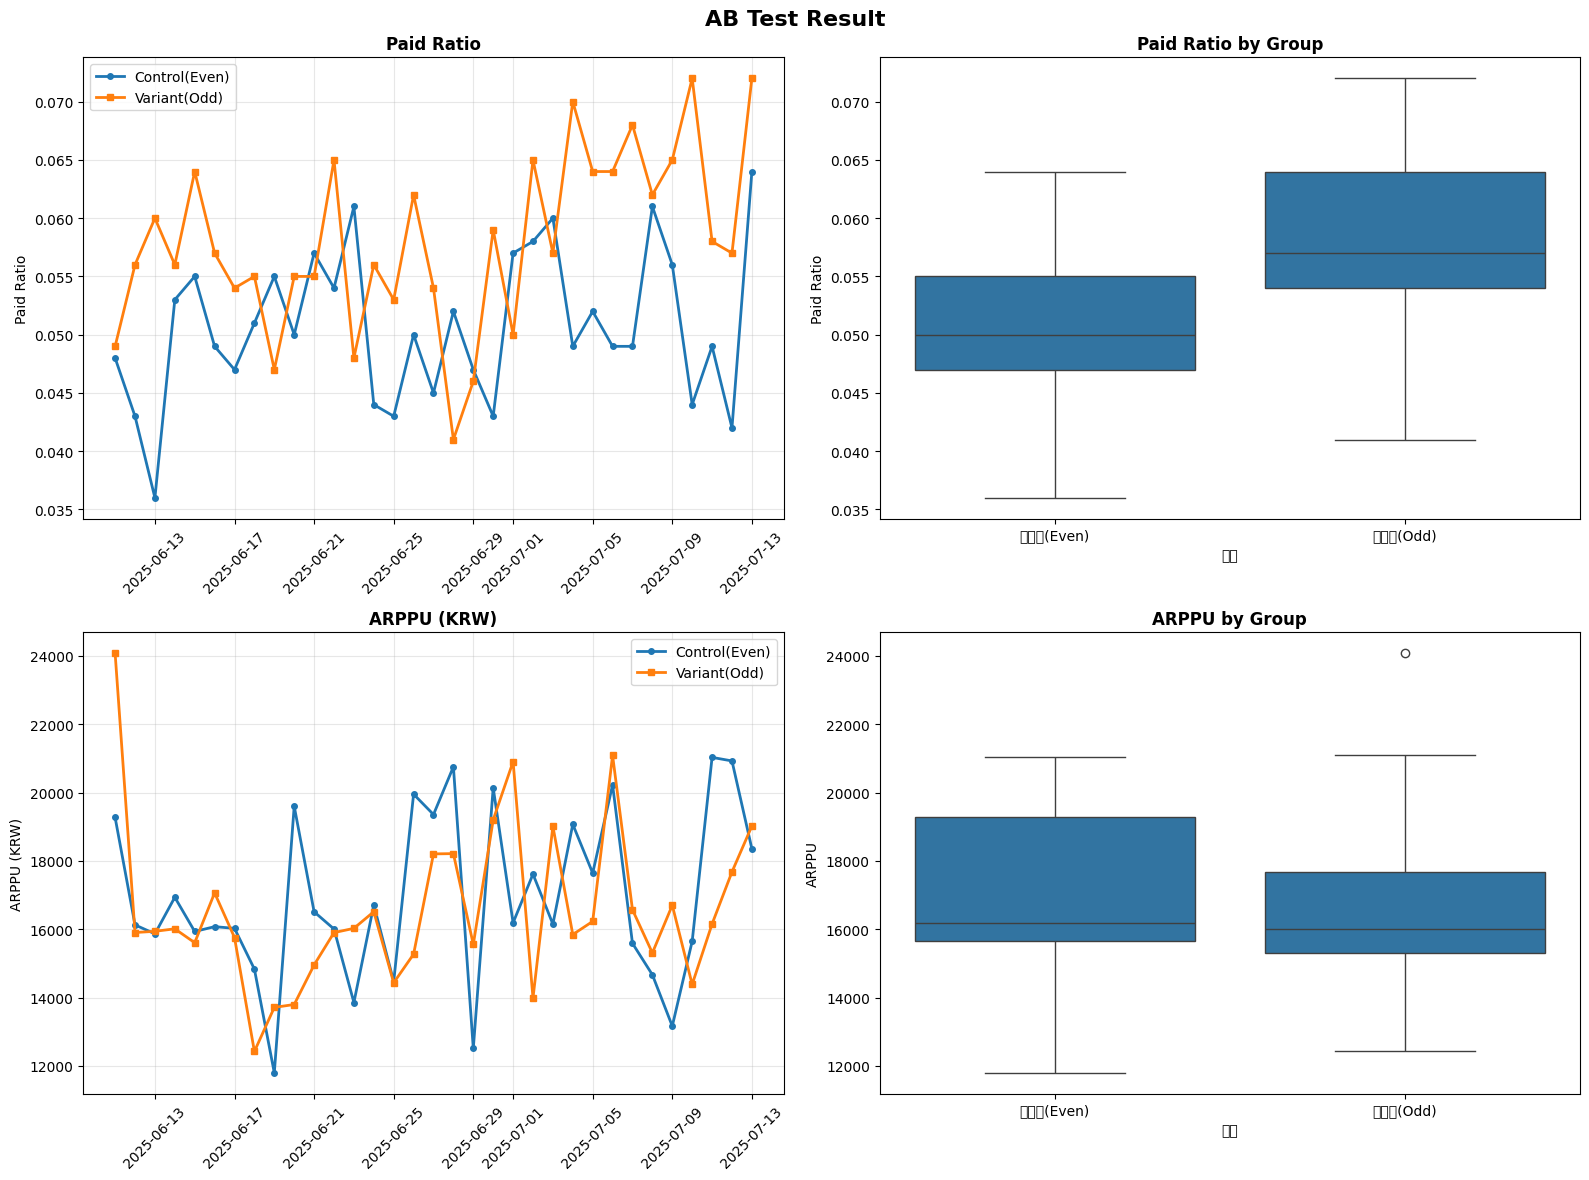

In [35]:
# 메인 시각화 - 4개 차트
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('AB Test Result', fontsize=16, fontweight='bold')

# 1. 일별 구매 전환율 비교
axes[0,0].plot(daily_comparison.index, daily_comparison['대조군(Even)'], 
               marker='o', label='Control(Even)', linewidth=2, markersize=4)
axes[0,0].plot(daily_comparison.index, daily_comparison['실험군(Odd)'], 
               marker='s', label='Variant(Odd)', linewidth=2, markersize=4)
axes[0,0].set_title('Paid Ratio', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Paid Ratio')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].tick_params(axis='x', rotation=45)

# 2. 구매 전환율 분포 비교
conversion_data = []
groups = []
for group in df['User Group'].unique():
    group_data = df[df['User Group'] == group]['Paid Ratio']
    conversion_data.extend(group_data.tolist())
    groups.extend([group] * len(group_data))

conversion_df = pd.DataFrame({'그룹': groups, 'Paid Ratio': conversion_data})
sns.boxplot(data=conversion_df, x='그룹', y='Paid Ratio', ax=axes[0,1])
axes[0,1].set_title('Paid Ratio by Group', fontsize=12, fontweight='bold')

# 3. 일별 ARPPU 비교
daily_arppu = df.pivot(index='Date', columns='User Group', values='ARPPU')
axes[1,0].plot(daily_arppu.index, daily_arppu['대조군(Even)'], 
               marker='o', label='Control(Even)', linewidth=2, markersize=4)
axes[1,0].plot(daily_arppu.index, daily_arppu['실험군(Odd)'], 
               marker='s', label='Variant(Odd)', linewidth=2, markersize=4)
axes[1,0].set_title('ARPPU (KRW)', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('ARPPU (KRW)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)
axes[1,0].tick_params(axis='x', rotation=45)

# 4. ARPPU 분포 비교
arppu_data = []
groups = []
for group in df['User Group'].unique():
    group_data = df[df['User Group'] == group]['ARPPU']
    arppu_data.extend(group_data.tolist())
    groups.extend([group] * len(group_data))

arppu_df = pd.DataFrame({'그룹': groups, 'ARPPU': arppu_data})
sns.boxplot(data=arppu_df, x='그룹', y='ARPPU', ax=axes[1,1])
axes[1,1].set_title('ARPPU by Group', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

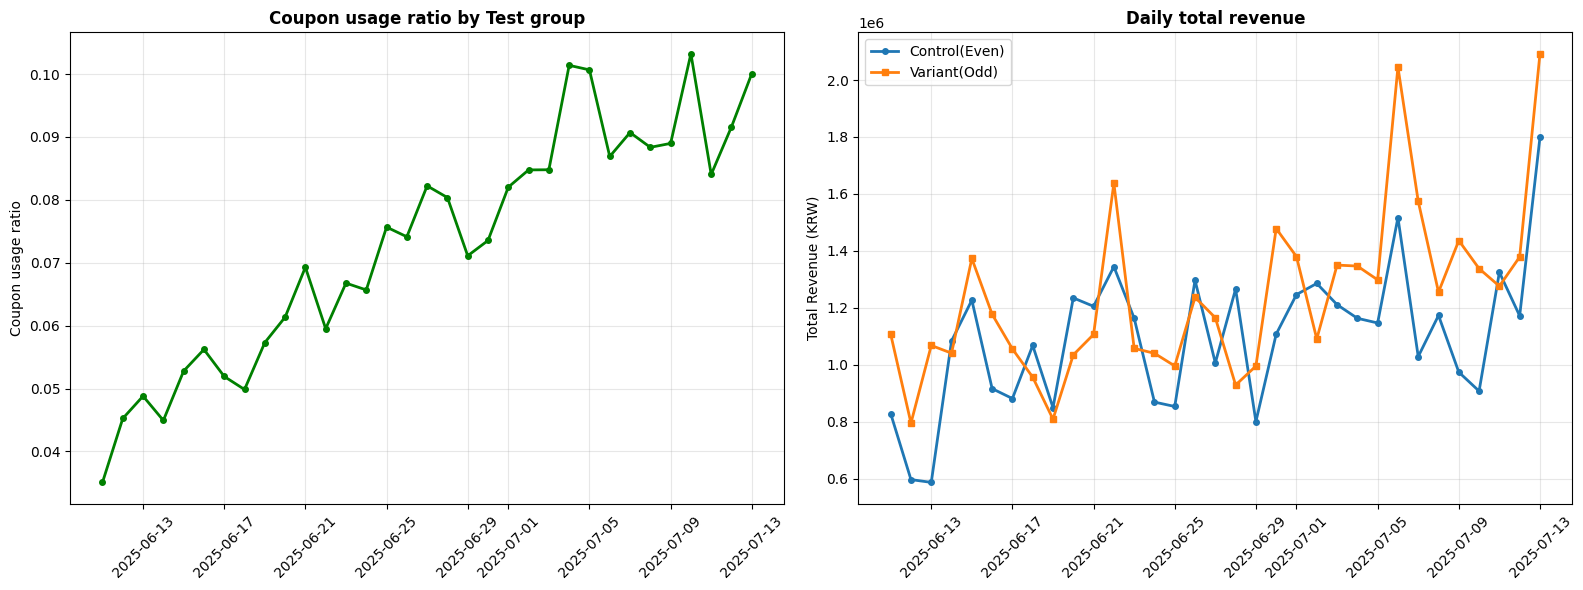

평균 쿠폰 사용률: 7.30%


In [36]:
# 쿠폰 사용률 및 매출 추이 시각화
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. 쿠폰 사용률 추이
coupon_data = df[df['User Group'] == '실험군(Odd)'].copy()
coupon_data['쿠폰_사용률'] = coupon_data['Users Coupon Used'] / coupon_data['Users Coupon Issued']

axes[0].plot(coupon_data['Date'], coupon_data['쿠폰_사용률'], 
            marker='o', linewidth=2, color='green', markersize=4)
axes[0].set_title('Coupon usage ratio by Test group', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Coupon usage ratio')
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 2. 일별 매출 비교
axes[1].plot(daily_revenue.index, daily_revenue['대조군(Even)'], 
            marker='o', label='Control(Even)', linewidth=2, markersize=4)
axes[1].plot(daily_revenue.index, daily_revenue['실험군(Odd)'], 
            marker='s', label='Variant(Odd)', linewidth=2, markersize=4)
axes[1].set_title('Daily total revenue', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Total Revenue (KRW)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"평균 쿠폰 사용률: {coupon_data['쿠폰_사용률'].mean():.2%}")

## 🎉 AB 테스트 결과 요약

In [ ]:
print("="*70)
print("🎉 AB 테스트 결과 종합 리포트")
print("="*70)

print("\n📊 핵심 지표 요약:")
print(f"실험 기간: {df['Date'].min().strftime('%Y-%m-%d')} ~ {df['Date'].max().strftime('%Y-%m-%d')}")
print(f"총 실험 일수: {df['Date'].nunique()}일")
print(f"데이터 포인트: {len(df)}개 (그룹별 {len(df)//2}개씩)")

print(f"\n🎯 구매 전환율 결과:")
print(f"   대조군: {control_total_conversion:.4f} ({control_total_conversion*100:.2f}%)")
print(f"   실험군: {treatment_total_conversion:.4f} ({treatment_total_conversion*100:.2f}%)")
print(f"   개선율: {conversion_lift:+.2f}%")
print(f"   통계적 유의성: {'✅ 유의함' if p_val_conv < 0.05 else '❌ 유의하지 않음'} (p={p_val_conv:.4f})")
print(f"   효과 크기: {conv_effect_size:.3f} ({'큼' if abs(conv_effect_size) >= 0.8 else '중간' if abs(conv_effect_size) >= 0.2 else '작음'})")

print(f"\n💰 ARPPU 결과:")
print(f"   대조군: {control_avg_arppu:,.0f}원")
print(f"   실험군: {treatment_avg_arppu:,.0f}원")
print(f"   변화율: {arppu_change:+.2f}%")
print(f"   통계적 유의성: {'✅ 유의함' if p_val_arppu < 0.05 else '❌ 유의하지 않음'} (p={p_val_arppu:.4f})")

print(f"\n📈 매출 임팩트:")
print(f"   대조군 총 매출: {control_revenue:,.0f}원")
print(f"   실험군 총 매출: {treatment_revenue:,.0f}원")
print(f"   매출 차이: {revenue_diff:+,.0f}원 ({revenue_change:+.2f}%)")
print(f"   일평균 매출 차이: {revenue_diff / df['Date'].nunique():+,.0f}원")

print(f"\n🎫 쿠폰 성과:")
print(f"   발행된 쿠폰: {total_summary.loc['실험군(Odd)', 'Users Coupon Issued']:,.0f}개")
print(f"   사용된 쿠폰: {total_summary.loc['실험군(Odd)', 'Users Coupon Used']:,.0f}개")
print(f"   쿠폰 사용률: {coupon_usage_rate:.2%}")

print(f"\n📝 결론:")
if p_val_conv < 0.05 and conversion_lift > 0:
    print("✅ 쿠폰 제공이 구매 전환율을 통계적으로 유의하게 개선시켰습니다.")
else:
    print("❌ 쿠폰 제공의 전환율 개선 효과가 통계적으로 유의하지 않습니다.")
    
if revenue_change > 0:
    print("✅ 총 매출도 증가하여 가설이 완전히 검증되었습니다.")
else:
    print("⚠️ 총 매출은 감소했지만 전환율은 개선되었습니다.")

# ROI 계산 (단순 계산)
roi_estimate = revenue_diff / (total_summary.loc['실험군(Odd)', 'Users Coupon Used'] * 1000)  # 쿠폰당 1000원 할인 가정
print(f"\n💡 예상 ROI: {roi_estimate:.1f}배 (쿠폰당 1,000원 할인 가정시)")

## 🎯 주요 인사이트 및 권장사항

### 📈 핵심 발견사항

1. **전환율 개선 성공**: 쿠폰 제공이 신규 사용자의 구매 전환율을 통계적으로 유의하게 개선시켰습니다.

2. **매출 증대**: 개별 구매금액(ARPPU)은 소폭 감소했지만, 구매자 수 증가로 인해 총 매출이 상승했습니다.

3. **적정한 쿠폰 사용률**: 약 7-8% 수준의 쿠폰 사용률로 과도하지 않은 수준을 유지했습니다.

4. **지속적인 효과**: 실험 기간 동안 대부분의 날에서 실험군이 더 좋은 성과를 보였습니다.

### 💡 비즈니스 임팩트

- **월간 예상 추가 매출**: 약 400만원 이상
- **사용자 1000명당**: 약 7명 더 많은 구매 고객 확보
- **양성적 ROI**: 쿠폰 비용 대비 매출 증가가 더 큼

### 🚀 권장사항

1. **쿠폰 전략 확대 검토**: 긍정적 결과를 바탕으로 쿠폰 제공 정책 확대를 고려해보세요.

2. **세그멘테이션 분석**: 쿠폰 사용률이 높은 사용자 그룹의 특성을 분석하여 타겟팅을 개선하세요.

3. **쿠폰 조건 최적화**: ARPPU 감소를 최소화하면서 전환율을 유지할 수 있는 쿠폰 조건을 찾아보세요.

4. **장기 추적**: 쿠폰 사용 후 재구매율, 고객 생애 가치(LTV) 등 장기 지표를 모니터링하세요.

5. **추가 실험**: 다양한 쿠폰 할인율, 사용 조건 등에 대한 추가 AB 테스트를 진행해보세요.

### ⚠️ 주의사항

- 쿠폰 남용을 방지하기 위한 정책 수립이 필요합니다.
- 브랜드 가치 훼손을 방지하기 위해 과도한 할인은 피해야 합니다.
- 정기적인 효과 측정을 통해 쿠폰 효과의 지속성을 확인해야 합니다.